In [1]:
#Necessary
from fastai.fastai.text import *
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import html
import csv

C:\Users\leond\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Necessary
BOS = "xbos " #beginning-of-sentence tag
CLASSES = ["hate", "offensive","neither"]
TAG = "xnametag"
EMOJI = "xemojitag "


In [3]:
#Necessary
PATH=Path("HateSpeech/")
CLAS_PATH = Path("emo_clas/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("emo_lm/")
LM_PATH.mkdir(exist_ok=True)

In [4]:
#Necessary
#https://arxiv.org/abs/1705.09899
def get_texts(path):
    texts, labels, data = [],[],[]
    with open(path, "r", encoding="utf-8") as dataset:
        reader = csv.reader(dataset, delimiter=",")
        next(reader, None)
        data = list(reader)
    dataset.close()
    for line in data:
        texts.append(BOS+line[-1])
        labels.append(line[-2])
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_texts(PATH/"labeled_data.csv")
part10k = int(len(trn_texts)/10)
print(part10k*10)
tst_texts, tst_labels = trn_texts[:part10k], trn_labels[:part10k]
val_texts, val_labels = trn_texts[part10k:2*part10k], trn_labels[part10k:2*part10k]
trn_texts, trn_labels = trn_texts[part10k*2:], trn_labels[part10k*2:]

24780


In [258]:
len(trn_texts), len(val_texts), len(tst_texts), len(trn_texts)+len(val_texts)+len(tst_texts)

(19827, 2478, 2478, 24783)

In [259]:
trn_texts[:10], trn_labels[:10]

(array(['xbos @TheRealCVL and @CoryHolmes24 are faggots. Kbye.',
        'xbos @TheRealCortlan All the thirsty hoes. Lol',
        "xbos @TheRealDiamondJ I'm the type to put that bitch in a river so you can gtf out my locations lol",
        'xbos @TheRealJRSmith And its people like you that give us all a bad name, you are a disgusting piece of shit of a person a nigger is what you are',
        'xbos @TheRealJohn_Doe dude fucking mono sucks and my bed is trash',
        'xbos @TheRealJohn_Doe thats nate dumbass we all just mock him',
        'xbos @TheRealKevinMcB Sauerkraut Saul is a punk ass bitch',
        'xbos @TheRealOweifie You do it to us so payback is a bitch. hahaha &lt;3 happy valentines day though.',
        'xbos @TheRealOweifie good one you fucking bitch ass',
        "xbos @TheRealSaigon What are you gonna do? I'ma chase you out the club, like mobb deep did to you, pussy."],
       dtype='<U759'),
 array(['0', '1', '1', '0', '1', '1', '1', '1', '1', '1'], dtype='<U1'))

In [5]:
#Necessary
col_names = ["labels", "text"]

In [6]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))
tst_idx = np.random.permutation(len(tst_texts))

In [7]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]
tst_texts = val_texts[tst_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]
tst_labels = val_labels[tst_idx]

In [8]:
tst_texts[:10], tst_labels[:10]

(array(["xbos @Kevin_McAdams Because Ian's retarded",
        'xbos @Rugarickrockers Ima make you a sick entrance song my nig',
        'xbos @GossipCop jay-z and bey they will never be..jus trash',
        "xbos @FukknTyler nigga I talk shit period this ain't nun new white bitch we go threw this every damn day &#128514;&#128514;",
        'xbos @LilReese300 what are you doing up right now Tavares. Kickin my bitch to curb for being too dramatic again?',
        "xbos @CrackerJhak Because you're a fag",
        'xbos @Stvtch_ @IAMBJRAPS @cheffin_curry @GirlTimeUSA @LILBTHEBASEDGOD bitch you look like a shamu go back to seaword',
        "xbos @Honey_GotBunns bitch you know you won't this &#128526;&#128131;&#128588;&#128514;",
        'xbos @NYRKelsMads That pup was like, this bitch is AWESOME! Can I go home with YOU?',
        'xbos @Pepper_Redbone @Yankees @Mets I miss the pizza! The passion.'], dtype='<U759'),
 array(['0', '1', '2', '1', '1', '0', '1', '1', '1', '2'], dtype='<U1'))

In [9]:
#Necessary
df_trn = pd.DataFrame({"text":trn_texts, "labels":trn_labels}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":val_labels}, columns=col_names)
df_tst = pd.DataFrame({"text":tst_texts, "labels":tst_labels}, columns=col_names)

Get Weights for class imbalance

In [10]:
#Necessary
trn_labelcounts = df_trn.groupby(["labels"]).size()
val_labelcounts = df_val.groupby(["labels"]).size()
tst_labelcounts = df_tst.groupby(["labels"]).size()
trn_label_sum = len(df_trn["labels"])
val_label_sum = len(df_val["labels"])
tst_label_sum = len(df_tst["labels"])
trn_weights = [count/trn_label_sum for count in trn_labelcounts]
val_weights = [count/val_label_sum for count in val_labelcounts]
tst_weights = [count/tst_label_sum for count in tst_labelcounts]
avg_weights = (np.array(trn_weights)+np.array(val_weights)+np.array(tst_weights))/3
avg_weights, val_weights

(array([0.08885, 0.73582, 0.17533]),
 [0.10694108151735271, 0.7138821630347054, 0.1791767554479419])

In [11]:
#Necessary
rtd_avg_weights = [max(avg_weights)/value for value in avg_weights]
rtd_trn_weights = [max(trn_weights)/value for value in trn_weights]
rtd_trn_weights, rtd_avg_weights

([14.807471264367816, 1.0, 4.65072202166065],
 [8.28197751536386, 1.0, 4.196660110215248])

In [267]:
df_trn.to_csv(CLAS_PATH/"train.csv", header=False, index=False)
df_val.to_csv(CLAS_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(CLAS_PATH/"tst.csv", header=False, index=False)

(CLAS_PATH/"classes.txt").open("w").writelines(f"{o}\n" for o in CLASSES)

In [268]:
df_trn.head()

,labels,text
0,1,xbos Heard some good news today and all I gott...
1,1,xbos That's the kind of bitch I hate fucking with
2,1,xbos If she hates being kissed in the mouth sh...
3,1,xbos RT @phishlicia: Ocho is approaching bitches
4,1,xbos Brooo Chinese sounds goooood then a hoe r...


In [12]:
(CLAS_PATH/"classes.txt").open().readlines()

['hate\n', 'offensive\n', 'neither\n']

In [13]:
df_trn = pd.DataFrame({"text":trn_texts, "labels":[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":[0]*len(val_texts)}, columns=col_names)
df_tst = pd.DataFrame({"text":tst_texts, "labels":[0]*len(tst_texts)}, columns=col_names)


df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(LM_PATH/"tst.csv", header=False, index=False)

Tokenization

In [14]:
def fixup(x):
    x = x.split()
    for i, word in enumerate(x):
        if "t.co" in word:
            del x[i]
        elif "@" in word:
            #x[i] = TAG
            del x[i]
        elif "&#" in word:
            """word = word.replace("&#", EMOJI)
            words = word.split(";")
            x[i] = " ".join(words)"""
            change = word.split("&#")
            x[i] = " ".join([word for thing in change for word in thing.split(";") if not word.isnumeric()])
    if x[1] == "RT":
        del x[1]
        del x[1]
    return " ".join(x)

In [15]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [16]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [17]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(LM_PATH/"tst.csv", header=None, chunksize=chunksize)

In [112]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

0
1
0
0


In [113]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [114]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)
np.save(LM_PATH/"tmp"/"tok_tst.npy",tok_tst)

In [18]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")
tok_tst = np.load(LM_PATH/"tmp"/"tok_tst.npy")

In [19]:
freq = Counter(p for o in tok_trn for p in o) #o = review (list of tokenized sentences), p = sentence
freq.most_common(25)

[('xbos', 19827),
 ('.', 8411),
 ('a', 7922),
 ('i', 7807),
 ('bitch', 6719),
 ('the', 5811),
 ('you', 5173),
 (',', 4611),
 ('to', 4421),
 ('that', 3274),
 ('and', 3242),
 ("n't", 3002),
 ('my', 2891),
 ('#', 2814),
 ('"', 2777),
 ('!', 2682),
 ('bitches', 2630),
 ('t_up', 2531),
 ('in', 2505),
 ('is', 2455),
 ('like', 2275),
 ('me', 2266),
 ('of', 2094),
 ('it', 2083),
 ('on', 2044)]

In [117]:
len(freq)

19247

In [20]:
max_vocab = 5000
min_freq = 5

In [21]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] #Sort out all words that apper less than max_vocab with bigger freq than min_freq
itos.insert(0, "_unk_") #words that did not appear before or not frequent enough
itos.insert(1, "_pad_")

In [22]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)}) #dictionary with index numbers sorted by freq
len(itos)

3242

In [121]:
tok_trn[-10:]

array([list(['xbos', 'i', 'do', 'not', 'love', 'these', 'hoes']),
       list(['xbos', 'halloween', '2011', 'a', 'spoopy', 'hoe', 'and', 'her', 'pimp', 'daddy']),
       list(['xbos', 'gator', "'s", 'bitches', 'best', 'be', 'usin', 'jimmy', "'s", '!']),
       list(['xbos', 'these', 'hoes', 'out', 'here', 'beefing', 'bout', 'as', 'important', 'as', 'these', 'hoes', 'out', 'here', 'queefing', '.', "y'", 'all', 'blowing', 'vaginal', 'wind', 'back', '&', 'amp', ';', 'forth', '.', 't_up', 'stfu', '&', 'amp', ';', 't_up', 'get', 't_up', 'money', '!']),
       list(['xbos', 'i', "'m", 'about', 'to', 'get', 'this', 'bitch', 'a', 'cell', 'mate']),
       list(['xbos', 'bitches', 'get', 'da', 'dick', 'they', 'be', 'dickmatized', '!']),
       list(['xbos', 'head', 'explosion', ':', 't_up', 'ww2', 'navajo', 'code', 'talkers', 'appear', 'in', 'redskins', 'jackets', '.', '#', 'redskins']),
       list(['xbos', 'i', 'got', 'a', 'gang', 'of', 'old', 'ass', 'drafts', ',', 'all', 'trash']),
       lis

In [122]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
tst_lm = np.array([[stoi[o] for o in p] for p in tok_tst])

In [123]:
np.save(LM_PATH/"tmp"/"trn_ids.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids.npy", val_lm)
np.save(LM_PATH/"tmp"/"tst_ids.npy", tst_lm)
pickle.dump(itos, open(LM_PATH/"tmp"/"itos.pkl","wb"))

In [23]:
#necessary
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids.npy")
tst_lm = np.load(LM_PATH/"tmp"/"tst_ids.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos.pkl","rb"))

In [24]:
#necessary
vs = len(itos) #vocabsize
vs, len(trn_lm), len(val_lm), len(tst_lm)

(3242, 19827, 2478, 2478)

Wikitext103

In [25]:
#necessary
em_sz,nh,nl = 400,1150,3 #embedding, hidden_size, hidden_layer - values of original wikitext model

In [26]:
PRE_PATH = PATH/"models"/"sem140"
PRE_LM_PATH = PRE_PATH/"sem140.h5"

In [27]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage) #load wikitext weights

In [28]:
enc_wgts = to_np(wgts["0.encoder.weight"])
row_m = enc_wgts.mean(0) #mean used for unknown tokens

Map Vocabularies on each other

In [29]:
itos2 = pickle.load((PRE_PATH/"itos_sem140.pkl").open("rb"))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
len(stoi2)

41813

In [30]:
new_w = np.zeros((vs, em_sz), dtype=np.float32) #0-matrix vocab-size*embedding-size
for i,w in enumerate(itos): #Go through vocab of turn dataset
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m #if word exists copy weight, otherwise average weight

In [31]:
wgts["0.encoder.weight"] = T(new_w)
wgts["0.encoder_with_dropout.embed.weight"] = T(np.copy(new_w))
wgts["1.decoder.weight"] = T(np.copy(new_w))

## Language Model

In [78]:
wd = 1e-4
bptt = 70
bs = 150
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [79]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
tst_dl = LanguageModelLoader(np.concatenate(tst_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, tst_dl, bs=bs, bptt=bptt)

In [80]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1.2 #1.8 smaller dataset = higher multiplicator

In [81]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()
md.test_dl.data = md.test_dl.data.long()

Initialize missing tokens with mean weights. So freeze everything except last layer

In [82]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [83]:
learner.model.load_state_dict(wgts)

In [84]:
learner.lr_find2(start_lr=0.01,end_lr=0.35, wds=wd, num_it=29)

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.rnns.0.module.weight_hh_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.2.module.weight_hh_l0". 

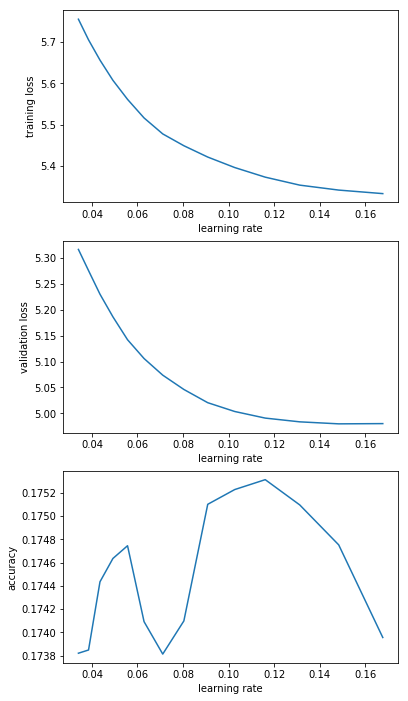

In [85]:
learner.sched.plot()

In [86]:
lrs = 0.09

In [87]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.21657    4.537219   0.199255  


[4.537219285964966, 0.19925536215305328]

In [88]:
learner.freeze_to(-2)

In [89]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.812145   4.597567   0.206736  


[4.597567319869995, 0.20673634856939316]

In [90]:
learner.save('lm_last_ft')

In [91]:
learner.load('lm_last_ft')

In [92]:
learner.unfreeze()

In [93]:
learner.lr_find2(start_lr=0.0001, end_lr=0.1, num_it=28, wds=wd)

 97%|████████████████████████████████████████████████████████████████████▌  | 28/29 [00:11<00:00,  2.49it/s, loss=5.02]

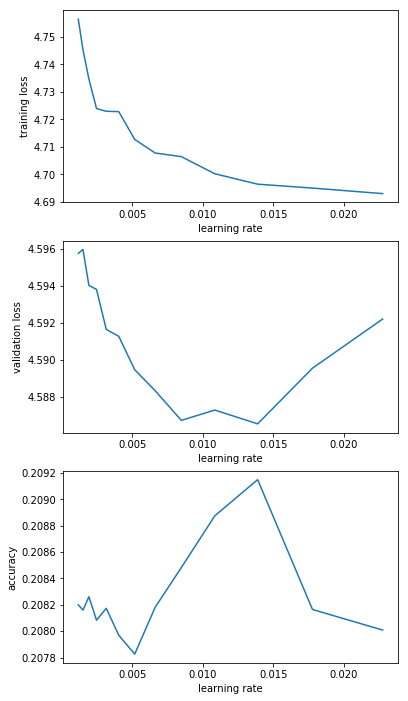

In [94]:
learner.sched.plot()

In [95]:
lrs = 0.01

In [96]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=10, best_save_name="best_lm")

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.650682   4.55209    0.218133  
    1      4.64652    4.533311   0.218533                                                                              
    2      4.651195   4.5262     0.20914                                                                               
    3      4.61118    4.528703   0.218205                                                                              
    4      4.590719   4.48589    0.224269                                                                              
    5      4.561095   4.495224   0.221098                                                                              
    6      4.510382   4.448407   0.229929                                                                              
    7      4.467838   4.45274    0.227007                                                                           

[4.416252374649048, 0.2310934141278267]

In [97]:
learner.save("lm1")

In [98]:
learner.load("best_lm")

In [99]:
learner.save_encoder("lm1_enc")

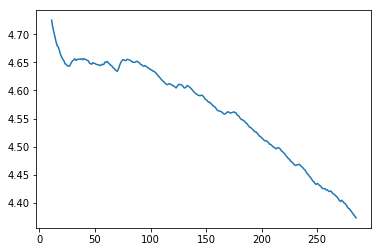

In [100]:
learner.sched.plot_loss()

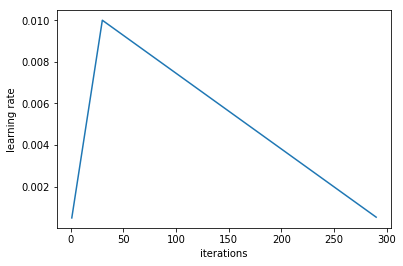

In [101]:
learner.sched.plot_lr()

In [102]:
df_trn = pd.read_csv(CLAS_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/"tst.csv", header=None, chunksize=chunksize)

In [103]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tol_tst, tst_labels = get_all(df_tst, 1)

0
1
0
0


In [104]:
(CLAS_PATH/"tmp").mkdir(exist_ok=True)

np.save(CLAS_PATH/"tmp"/"tok_trn.npy", tok_trn)
np.save(CLAS_PATH/"tmp"/"tok_val.npy", tok_val)
np.save(CLAS_PATH/"tmp"/"tok_tst.npy", tok_tst)

np.save(CLAS_PATH/"tmp"/"trn_labels.npy", trn_labels)
np.save(CLAS_PATH/"tmp"/"val_labels.npy", val_labels)
np.save(CLAS_PATH/"tmp"/"tst_labels.npy", tst_labels)

In [32]:
#necessary
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/"tmp"/"tok_tst.npy")

In [33]:
#Necessary
itos = pickle.load((LM_PATH/"tmp"/"itos.pkl").open("rb"))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3242

In [107]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [108]:
np.save(CLAS_PATH/"tmp"/"trn_ids.npy", trn_clas)
np.save(CLAS_PATH/"tmp"/"val_ids.npy", val_clas)
np.save(CLAS_PATH/"tmp"/"tst_ids.npy", tst_clas)

## Classifier

In [34]:
#Necessary
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
tst_clas = np.load(CLAS_PATH/"tmp"/"tst_ids.npy")

In [35]:
#Necessary
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
tst_labels = np.squeeze(np.load(CLAS_PATH/"tmp"/"tst_labels.npy"))

In [111]:
#Necessary
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 150

In [112]:
#Necessary
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
tst_labels -= min_lbl
c=int(trn_labels.max())+1

In [113]:
#Necessary
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
tst_ds = TextDataset(tst_clas, tst_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))  #sorts dataset by length to reduce too strongly padded tensors
tst_samp = SortSampler(tst_clas, key=lambda x: len(tst_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, tst_dl)

In [114]:
#Necessary
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1.4

In [115]:
#Necessary
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                       layers=[em_sz*3, 50,c], drops=[dps[4], 0.2],
                      dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
#check dropout layers

In [116]:
#Necessary
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]
loss_weights = torch.FloatTensor(rtd_avg_weights).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)

In [117]:
wd = 7e-2
learn.load_encoder("lm1_enc")

In [118]:
learn.unfreeze()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.068547   1.107073   0.678497  


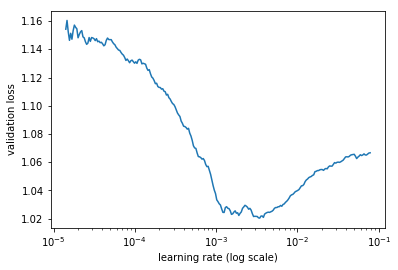

In [119]:
learn.lr_find(end_lr=1e-1, wds=wd)
learn.sched.plot()

In [120]:
lrs = 5*10e-4

In [121]:
learn.freeze_to(-1)

In [122]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm1')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.821916   0.839907   0.742534  


[0.8399067646654698, 0.7425343236969401]

In [123]:
learn.save('clas_0')

In [124]:
learn.load('clas_0')

In [125]:
learn.freeze_to(-2)

In [126]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm2')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.689444   0.627142   0.771186  


[0.6271418703237399, 0.7711864597283611]

In [127]:
learn.save('clas_1')

In [139]:
learn.load('clas_1')

In [140]:
learn.unfreeze()

 94%|████████████████████████████████████████████████████████████████▏   | 250/265 [00:23<00:01, 10.33it/s, loss=0.689]

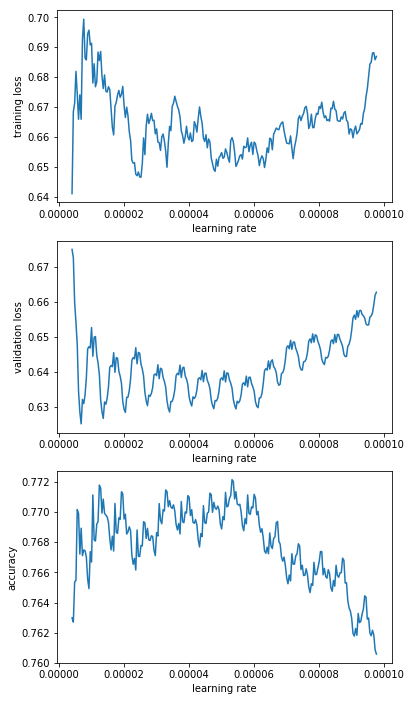

In [143]:
learn.lr_find2(num_it=250,start_lr=10e-6, end_lr=1e-4, wds=wd, linear=True)
learn.sched.plot()

In [144]:
lrs = 4e-5

In [145]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=10, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_classifier')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.640797   0.61657    0.766747  
    1      0.654003   0.615311   0.770379                                                                              
    2      0.611006   0.585186   0.768765                                                                              
    3      0.637521   0.577617   0.764326                                                                              
    4      0.599767   0.574564   0.765133                                                                              
    5      0.595174   0.560409   0.779257                                                                              
    6      0.608477   0.552236   0.768362                                                                              
    7      0.586088   0.551303   0.776433                                                                           

[0.5617820738158561, 0.7764326245963717]

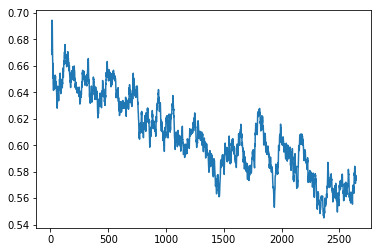

In [146]:
learn.sched.plot_loss()

In [147]:
learn.save('clas_2')

In [148]:
learn.load("best_classifier")

In [149]:
val_lbls = np.load(CLAS_PATH/'tmp'/'val_labels.npy').flatten()
val_lbls_sampled = val_lbls[list(val_samp)]
predictions = np.argmax(learn.predict(), axis=1)
acc = (val_lbls_sampled == predictions).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1,2]
print(confusion_matrix(val_lbls_sampled, predictions, labels=clas_labels))
print("F-Score: ", f1_score(val_lbls_sampled, predictions, average="weighted"))
print("Sem-eval F-Score: ", f1_score(val_lbls_sampled, predictions, labels=[0,1,2], average="micro"))


print(classification_report(val_lbls_sampled, predictions))


Accuracy = 0.7792574656981437 , 
Confusion Matrix =
[[ 180   36   49]
 [ 276 1334  159]
 [  15   12  417]]
F-Score:  0.7965511471893032
Sem-eval F-Score:  0.7792574656981437
             precision    recall  f1-score   support

          0       0.38      0.68      0.49       265
          1       0.97      0.75      0.85      1769
          2       0.67      0.94      0.78       444

avg / total       0.85      0.78      0.80      2478



In [150]:
tst_lbls_sampled = np.load(CLAS_PATH/'tmp'/'tst_labels.npy').flatten()
#tst_lbls_sampled = tst_lbls[list(tst_samp)]
predictions = np.argmax(learn.predict(True), axis=1)
acc = (tst_lbls_sampled == predictions).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1]
print(confusion_matrix(tst_lbls_sampled, predictions, labels=clas_labels))
print("F-Score: ", f1_score(tst_lbls_sampled, predictions, average="weighted"))
print("Sem-eval F-Score: ", f1_score(tst_lbls_sampled, predictions, labels=[0,1], average="micro"))


print(classification_report(tst_lbls_sampled, predictions))

Accuracy = 0.7933817594834544 , 
Confusion Matrix =
[[ 172   43]
 [ 225 1373]]
F-Score:  0.8066466257583393
Sem-eval F-Score:  0.7984496124031009
             precision    recall  f1-score   support

          0       0.42      0.65      0.51       265
          1       0.96      0.78      0.86      1769
          2       0.66      0.95      0.78       444

avg / total       0.85      0.79      0.81      2478



## Submission

### Classifier weight tuning

In [151]:
predictions = np.argmax(learn.predict(True), axis=1)
predictions[:10]

array([2, 1, 2, 1, 1, 0, 1, 1, 1, 2], dtype=int64)

In [152]:
x = [1,1,1] #[0.3,0.5,1.5,1]
rtd_avg_weights_clas = [x[i]/value for i, value in enumerate(rtd_avg_weights)]
rtd_avg_weights_clas

[0.12074410950101042, 1.0, 0.23828472493301575]

In [153]:
preds = learn.predict(True)*rtd_avg_weights_clas
preds = np.argmax(preds, axis=1)
preds[:30], predictions[:30]

(array([2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1], dtype=int64),
 array([2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1], dtype=int64))

In [154]:
tst_lbls_sampled = np.load(CLAS_PATH/'tmp'/'tst_labels.npy').flatten()
#tst_lbls_sampled = tst_lbls[list(tst_samp)]
predictions = np.argmax(learn.predict(True), axis=1)
acc = (tst_lbls_sampled == preds).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1,2]
print(confusion_matrix(tst_lbls_sampled, preds, labels=clas_labels))
print("F-Score: ", f1_score(tst_lbls_sampled, preds, average="weighted"))
print("Sem-eval F-Score: ", f1_score(tst_lbls_sampled, preds, labels=[0,1,2], average="micro"))


print(classification_report(tst_lbls_sampled, preds))

Accuracy = 0.8022598870056498 , 
Confusion Matrix =
[[ 142   74   49]
 [ 174 1431  164]
 [   9   20  415]]
F-Score:  0.8104632682608217
Sem-eval F-Score:  0.8022598870056498
             precision    recall  f1-score   support

          0       0.44      0.54      0.48       265
          1       0.94      0.81      0.87      1769
          2       0.66      0.93      0.77       444

avg / total       0.84      0.80      0.81      2478



In [168]:
x = np.unique(preds, return_counts=True)
y = np.unique(predictions, return_counts=True)

x[1]/[[np.sum(x[1])]*len(x[1])], y[1]/[[np.sum(y[1])]*len(y[1])]

(array([[0.12228, 0.64568, 0.23204]]), array([[0.18079, 0.58071, 0.2385 ]]))

### Create output

In [145]:
def create_output():
    output = []
    output.append(["id","turn1", "turn2", "turn3", "label"])
    preds = learn.predict(True)*rtd_avg_weights_clas
    """for i, ele in enumerate(preds):
        if np.argmax(ele) == 3:
            preds[i][3] = -10"""
    predictions = np.argmax(preds, axis=1) #(True = Testset)
    
    
    for i, text in enumerate(tst_texts):
        turns = text.split("eot")
        output.append([str(i),turns[0].strip(), turns[1].strip(), turns[2].strip(), CLASSES[predictions[i]]])
    return output

In [146]:
def write_sample():
    outputs = create_output()
    with open("test.txt", "w", encoding="utf-8") as writer:
        for output_set in outputs:
            line = "\t".join(output_set)
            writer.write(line+"\n")
write_sample()

IndexError: list index out of range

In [ ]:
np.exp(3.91)